In [47]:
import tensorflow as tf
import pandas as pd
from window import WindowGenerator
import utils

# LSTM

## Datasets

In [48]:
case_1 = pd.read_csv("../datasets/case_1.csv", index_col='Time')
case_2 = pd.read_csv("../datasets/case_2.csv", index_col='Time')
case_3 = pd.read_csv("../datasets/case_3.csv", index_col='Time')
case_4 = pd.read_csv("../datasets/case_4.csv", index_col='Time')
case_5 = pd.read_csv("../datasets/case_5.csv", index_col='Time')

In [49]:
outlets = [ col for col in case_1.columns.values if col.startswith('outlet') ]
label_columns = outlets

num_features = len(label_columns)

In [50]:
column_indices = { name: i for i, name in enumerate(case_1.columns) }

## Train case function

In [51]:
def train_case(case_df:pd.DataFrame, model, in_width:int, out_steps:int, max_epochs:int):
    """ Train model for given case dataframe. """

    outlets = [ col for col in case_df.columns.values if col.startswith('outlet') ]
    column_indices = { name: i for i, name in enumerate(case_df.columns) }

    train_df, test_df, val_df = utils.train_test_val_split(case_df, test_size=0, val_size=0.2)
    # train_df, test_df, val_df = normalize_datasets(train_df, test_df, val_df)

    label_columns = outlets

    multi_window = WindowGenerator(
        train_df=train_df,
        val_df=val_df,
        test_df=test_df,
        input_width=in_width,
        label_width=out_steps,
        shift=out_steps,
        label_columns=label_columns
    )

    history = model.fit(
        multi_window.train,
        epochs=max_epochs,
        validation_data=multi_window.val,
        verbose=0
        # callbacks=[early_stopping]
    )

    return multi_window, history

## Model creation

In [52]:
IN_WIDTH = 18
OUT_STEPS = 18
MAX_EPOCHS = 30
features_size = len(label_columns)

In [53]:
multi_lstm_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units].
    # Adding more `lstm_units` just overfits more quickly.
    tf.keras.layers.LSTM(32, return_sequences=False),
    # Shape => [batch, out_steps*features].
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features].
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

In [54]:
multi_lstm_model.compile(loss=tf.losses.MeanSquaredError(),
                         optimizer=tf.optimizers.Adam(),
                         metrics=[tf.metrics.RootMeanSquaredError()])

## Case 2

In [55]:
window, history = train_case(
    case_df=case_2,
    model=multi_lstm_model,
    in_width=IN_WIDTH,
    out_steps=OUT_STEPS,
    max_epochs=MAX_EPOCHS
)

2022-09-26 17:07:57.676114: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-26 17:07:57.877240: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-26 17:07:57.979012: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-26 17:07:58.474352: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-26 17:07:58.550344: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


In [56]:
multi_lstm_model.build(input_shape=window.example[0].shape)
multi_lstm_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 32)                39168     
                                                                 
 dense_2 (Dense)             (None, 2448)              80784     
                                                                 
 reshape_2 (Reshape)         (None, 18, 136)           0         
                                                                 
Total params: 119,952
Trainable params: 119,952
Non-trainable params: 0
_________________________________________________________________


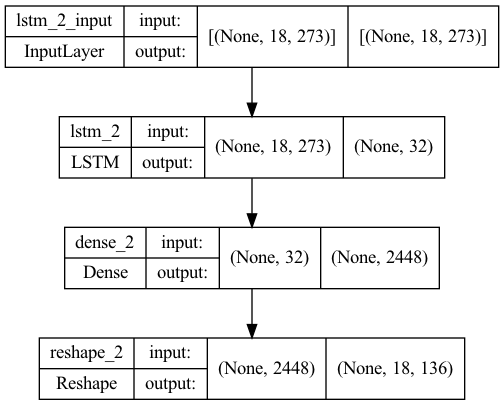

In [57]:
tf.keras.utils.plot_model(multi_lstm_model, "../plots/models/multi_lstm_model.png", show_shapes=True)

label_col_index 135


2022-09-26 17:08:07.833524: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-26 17:08:07.888414: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


label_col_index 135
label_col_index 135


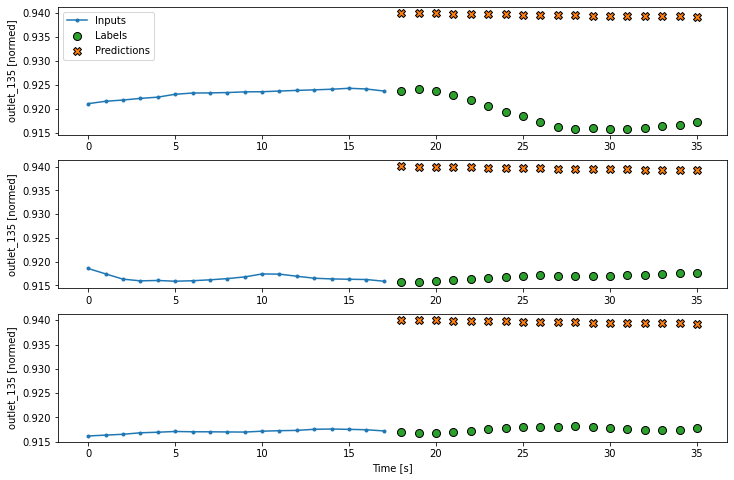

In [58]:
window.plot(multi_lstm_model, plot_col="outlet_135")

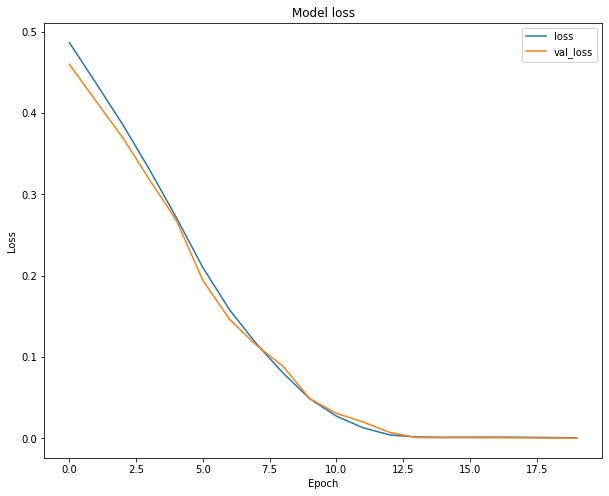

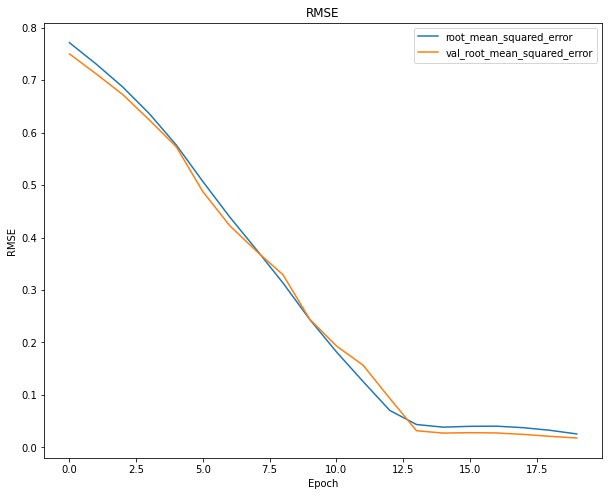

In [59]:
utils.plot_losses(history=history)

## Case 3

In [60]:
window, history = train_case(
    case_df=case_3,
    model=multi_lstm_model,
    in_width=IN_WIDTH,
    out_steps=OUT_STEPS,
    max_epochs=MAX_EPOCHS
)

label_col_index 135
label_col_index 135
label_col_index 135


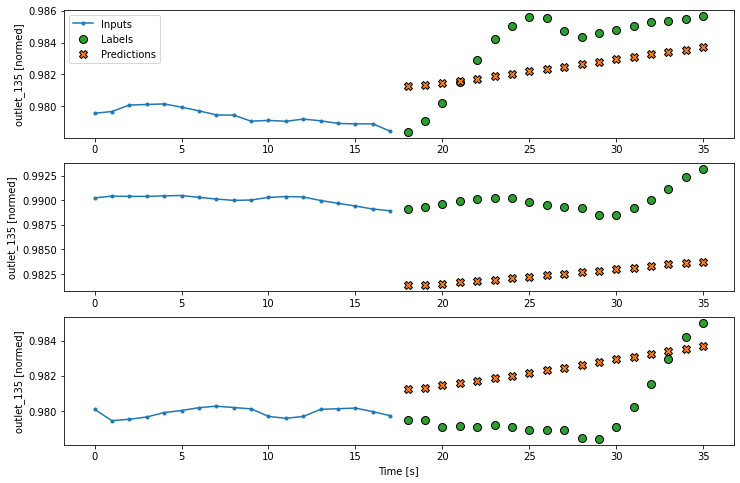

In [61]:
window.plot(multi_lstm_model, plot_col="outlet_135")

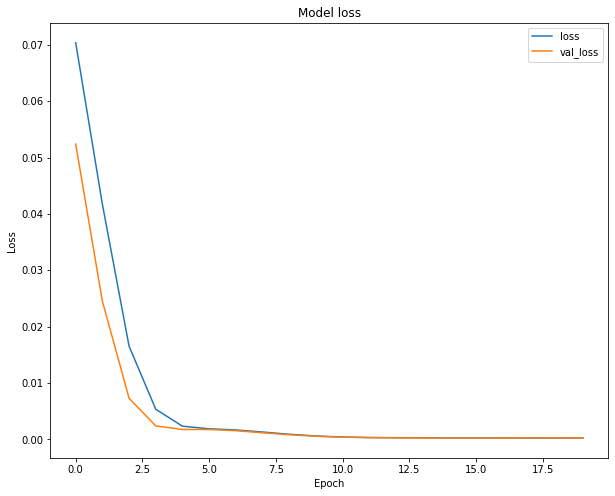

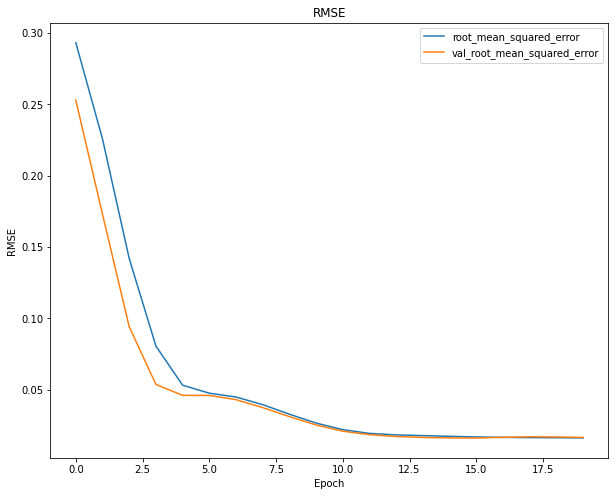

In [62]:
utils.plot_losses(history=history)

## Case 4

In [63]:
window, history = train_case(
    case_df=case_4,
    model=multi_lstm_model,
    in_width=IN_WIDTH,
    out_steps=OUT_STEPS,
    max_epochs=MAX_EPOCHS
)

label_col_index 135
label_col_index 135
label_col_index 135


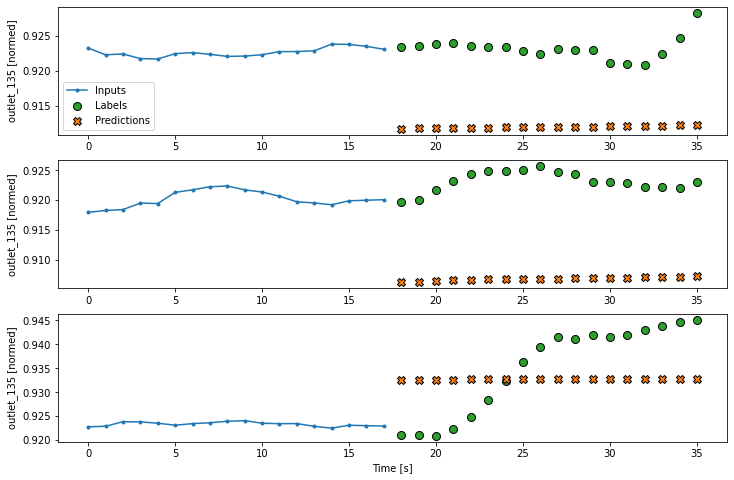

In [64]:
window.plot(multi_lstm_model, plot_col="outlet_135")

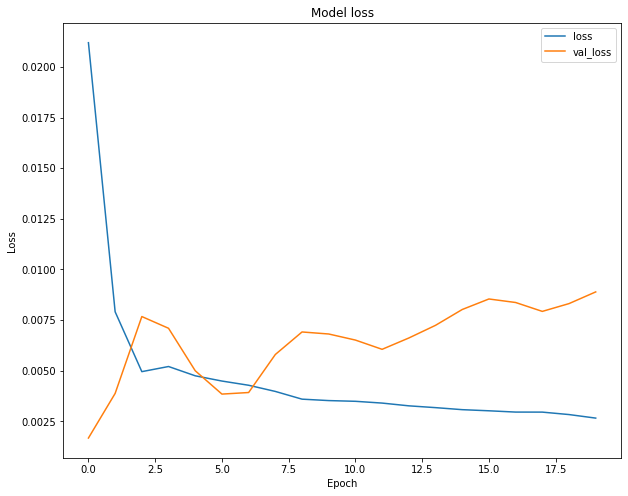

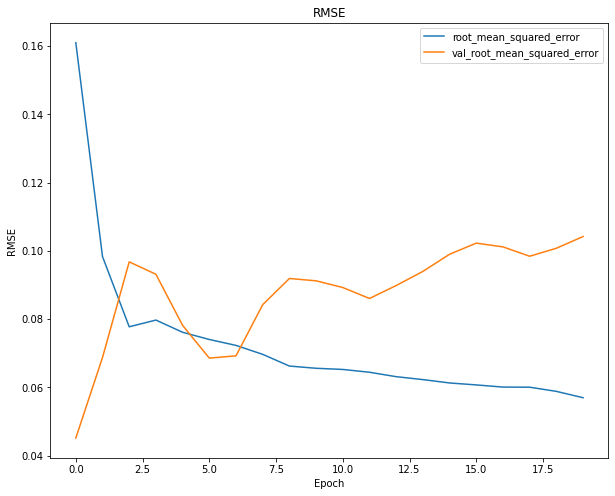

In [65]:
utils.plot_losses(history=history)

## Case 5

In [66]:
window, history = train_case(
    case_df=case_5,
    model=multi_lstm_model,
    in_width=IN_WIDTH,
    out_steps=OUT_STEPS,
    max_epochs=MAX_EPOCHS
)

label_col_index 135
label_col_index 135
label_col_index 135


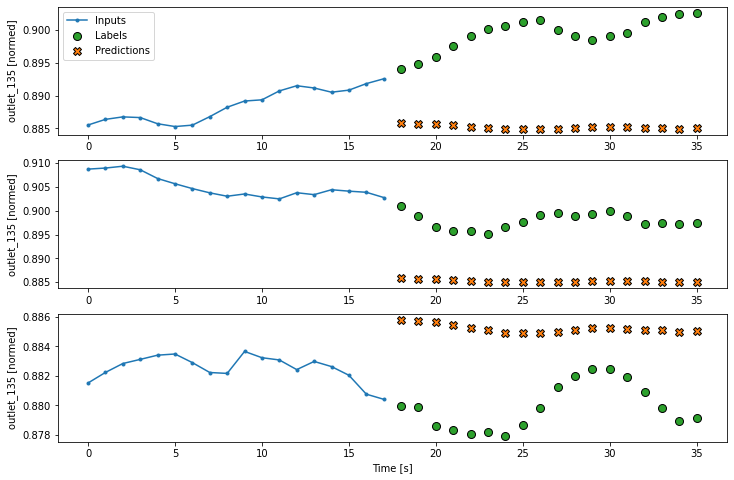

In [67]:
window.plot(multi_lstm_model, plot_col="outlet_135")

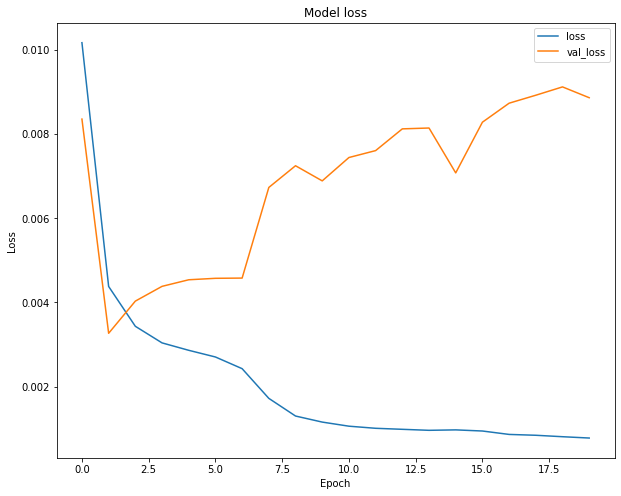

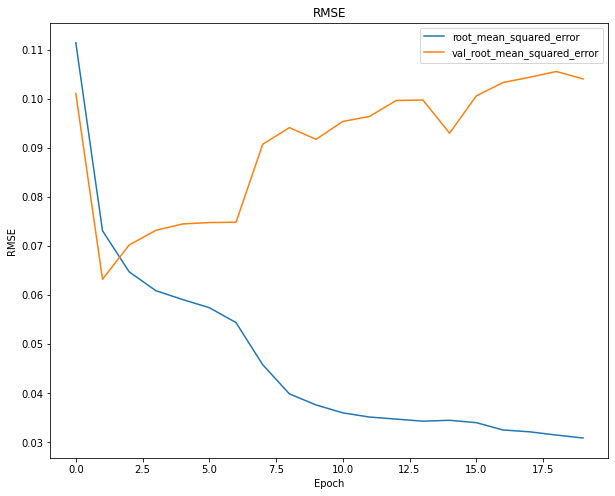

In [68]:
utils.plot_losses(history=history)

## Case 1 (Testing)

In [69]:
outlets = [ col for col in case_1.columns.values if col.startswith('outlet') ]
column_indices = { name: i for i, name in enumerate(case_1.columns) }

label_columns = outlets

window = WindowGenerator(
    train_df=case_1,
    input_width=IN_WIDTH,
    label_width=OUT_STEPS,
    shift=OUT_STEPS,
    label_columns=label_columns
)

multi_lstm_model.evaluate(window.train)

5/5 [==============================] - 0s 12ms/step - loss: 0.0246 - root_mean_squared_error: 0.1733


[0.024570608511567116, 0.17329376935958862]